<a href="https://colab.research.google.com/github/divyanshgupt/travelling-wave-mec/blob/main/Travelling_Wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Dependencies
import numpy as np
import tqdm
from matplotlib import pyplot as plt

## Grid Cells Encoding & Decoding Functions

In [2]:
def uniform_module(lam, orientation, cell_num_root):
  '''
  To generate a population of cells within a module (of varying 
  relative phase but sharing the same lattice spatial period
  and orientation). The relative phases are distributed uniformly

  *Args:
    lam - fixed spatial period for the module
    orientation
    cell_num - sq. root of number of cells in the module
  Returns:
   a 2-D array with cells along rows and three properties along y-axis:
  array[:,0, :] - lamda (Spatial Period)
  array[:,1, :] - orientation
  array[:,2] - x-coordinate of relative phase
  array[:,3] - y-coordinate of relative phase
  '''
  # intialize array of cell properties
  cell_num = cell_num_root**2
  array = np.ones((cell_num, 4))
  # x and y elements of the relative phase
  c_x = np.linspace(0, lam, cell_num_root)
  c_y = np.linspace(0, lam, cell_num_root)
  
  array[:, 0] = lam*array[:, 0]
  array[:, 1] = orientation*array[:,1]

  cell_iter = 0
  relative_phase = np.zeros((cell_num, 2))

  for i in range(cell_num_root):
    for j in range(cell_num_root):
      array[cell_iter, 2] = c_x[i]
      array[cell_iter, 3] = c_y[j]
      relative_phase[cell_iter] = array[cell_iter, 2:].T

      cell_iter += 1
  return array

def PopDecode2D(activity, lam, phases):
  '''
  *args:
    activity: array of population activity of shape (cell_num,)
    phases: array of cell spatial phases, shape: (cell_num, 2)
  returns:
    maximum likelihood estimate based on population vector in 2-D
    for a single module
  '''
  k1 = np.array([np.sqrt(3)/2, 1/2])
  k2 = np.array([0,1])
  k3 = np.array([-np.sqrt(3)/2, 1/2])
  k = np.vstack((k1, k2, k3))
  w = 2*np.pi / ((np.sqrt(3)/2)*lam)
  mu = np.zeros(3)

# to determine normalized popualtion vector projected onto k_l
  for i in range(3):
    exponent_vector = np.exp(1j*w*(phases@k[i]))
    mu[i] = (1/w)*np.angle(np.sum(activity * exponent_vector))

# the maximum likelihood estimate obtained by the intersection of the three lines 
  max_like_estim = (2/3) * (mu.T@k)

  return max_like_estim

def vonMisesTuning(x, lam, n_max, K, orientation, phases):
  '''
  To obtain activity of the given cell modeled using a von Mises Tuning Curve 
  following a poisson distribution 

  * args:
    x: 2-D vector for position coordinates
    lam - lamda, the spatial period
    n_max - maximum firing frequency of the tuning curve
    K - kappa, for the tuning-width
    orientation - lattice orientation
    phases - relative phase of the cell (2-D vector)

  returns: 
    (scalar) value of the vonMises tuning curve
     at the given position coordinates
  '''
  pi = np.pi 

  k1 = np.array([np.cos(pi/6), np.sin(pi/6)])
  k2 = np.array([np.cos(pi/2), np.sin(pi/2)])
  k3 = np.array([np.cos(pi*5/6), np.sin(pi*5/6)])
  plane_vectors = np.vstack((k1, k2, k3))

  w = (2*pi)/(np.sin(pi/3)*lam) # omega, for the periodicity of the tuning function

  position_argument = x - phases
  dot_prod = w * plane_vectors @ position_argument.T # the dot product of the plane vector with the position coordinate done for all three vectors
  von_mises_values = n_max * np.exp((K/3) * np.sum(np.cos(dot_prod) - 1, axis=0))
  
  return von_mises_values

def firing_activity(module, position, n_max, K):
  '''
  To obtain no. of spikes for each cell in given module in a given time bin
  for the given position. The cells are modelled using von Mises Tuning Curves
  and the firing activity using the Poisson distribution.

  *args:
    module: 3-D array of shape (cell num, 3, 2) with three columns being 
      lamda, orientation and relative phase. The relative phase is a 2-D vector
    position: a 2-D vector of position coordinates

  returns:
    von-Mises firing activity
  '''
  lam = module[0, 0]
  orientation = module[0, 1]
  phases = module[:, 2:]
  cell_num = len(module)

# evaluate the firing activity of the cell, as a sample from a poisson distribution 
# with mean value set to the value of the von_mises_value for the cell at the given position
  activity = np.random.poisson(vonMisesTuning(position, lam, n_max,
                                             K, orientation, phases))

  return activity

def multi_uniformModules(lam, orienation, 
                         cell_num_root,num_modules, s=1.5):
  '''
  To generate multiple uniform (relative phase) modules 
  with same orientation and the same number 
  of cells in each module.
  *Args:
    lam - spatial period of largest module
    orientation - orienation of the lattice
    cell_num - sq. root of number of cells in each module
    s - scaling factor (lamda_0/lamda_1)
    num_modules - number of modules
  Returns:
   list containing modules
  '''
  modules = []

  for i in range(num_modules):
    lam_module = lam/(s**i)
    module = uniform_module(lam, orientation, cell_num_root)
    modules.append(module)
  
  return modules

def multi_firing_activity(modules, position, n_max, K, s):
  '''
  To evaluate the firing activity of all given modules at given
  position, assuming von-Mises Tuning, independent poisson cells
  and modules and self-similarity.

  self similarity implies:
    vonMises(x, m-th module) = vonMises(s*x, 0th Module)
  *args:
    modules - list of all modules (each module is a 2-D array)
    position - 
    n_max - 
    K - tuning width of the von_Mises curve
    s - the scaling factor

  Returns:
    list containing activity arrays of all modules
    each activity array is a column vector having no. of spikes
    for all cells in the corresponding module
  '''
  multi_activity = np.zeros((len(modules[0]),len(modules)))

  for i in range(len(modules)):
    activity = firing_activity(modules[i], position, n_max, K)
    multi_activity[:,i]=activity
    K=K*s #reduce firing fields in successive modules

  return multi_activity  

def Nested_decoder2D(gridcells, multi_firing):
  '''
  Decodes position across multiple modules
  *args:
    gridcells-list of modules: with each module a 2d array as defined in multi_uniformModules
    multi_firing: firing rate of all cells in the modules (for one position), 2d array:rows are cells, cols: are modules
  Returns:
    mostlikely position and list of successive estimates based on nested decoding
  '''
  estimates = np.zeros((len(gridcells),2))

  for i in range(len(gridcells)):
    lam = gridcells[i][0,0]
    phases = gridcells[i][:, 2:]
    estimate = PopDecode2D(multi_firing[:,i], lam, phases)
    estimates[i] = estimate

  #recursive algorithm
  xl = estimates[0]
  cells0 = len(gridcells[0]) 
  lami0 = gridcells[0][0,0]
  prevnumer= cells0/(lami0**2)
  new_estimates = []
  for i in range(1,len(gridcells)):
    del_hat=estimates[i]-xl # centering next lattice around previous estimate
    #calculating weights
    cellsi_1 = len(gridcells[i-1])
    lami_1 = gridcells[i-1][0,0]
    numer = cellsi_1/(lami_1**2)
    new_estimates.append(xl)
    xl = xl+ (numer/prevnumer)*del_hat #multiplying by weights
    prevnumer += numer
      
  return xl, new_estimates

def trajectory_1(total_steps=10):
    """
    computes a random trajectory, returns 2d array where each row is x,y position
    """
    np.random.seed(54) #<--change trajectory
    x=np.random.uniform(low=0, high=8, size=total_steps)
    y =np.random.uniform(low=0, high=8, size=total_steps)
    traject=np.column_stack((x,y))

    return traject

def random_trajectory(total_steps =100, step_size=0.5):
    """
    plots & returns n*2 array of randomly generated postions
    """
    angle = np.random.rand(total_steps)*2*np.pi
    x = step_size*np.hstack((0, np.cos(angle)))
    y = step_size*np.hstack((0, np.sin(angle)))
    traject=np.column_stack((x,y)).cumsum(0)

    return traject


def decode_2dtraj_allm(traject, gridcells, K, n_max, s):
  '''
  decodes postion for an entire trajectory
  input: 
    traject, 2d array where rows are positons x,y
    gridcells: grid cells to generate firing patterns from (list of modules)
  returns:
    estimated trajectory
  '''

  estimates = np.zeros((len(traject),2))
  for i,pos in enumerate(traject):
    multi_firing=multi_firing_activity(gridcells, pos, n_max, K, s)
    est, _ = decode_2dpos_allm(gridcells,multi_firing)
    estimates[i] = est
  return estimates

## Travelling Wave

Time is intricately linked with the notion of a travelling wave, so to implement the wave, the context information of time is needed in some global variable. This can be done using the trajectory of the animal which can be represented as a time series of position.

In [3]:

def modulating_factor(modules, trajectory, freq, dt):
  """
  Input:
    modules
    trajectory: 2D position array (timeseries)to extract time by obtaining length of this array
    freq: frequency of the wave
  Returns:
    2-D array of modulating factors of shape (num_modules, timesteps)
  """
  pi = np.pi

  num_timesteps = len(trajectory)
  num_modules = len(modules)
  modulating_factors = np.zeros((num_modules, num_timesteps))
#  print(modulating_factors.shape)

  T = 1/freq # Time period of the wave
  w = 2*pi/T # omega, the angular frequency of the wave

  for t in range(num_timesteps):
    for i in range(num_modules):
      modulating_factors[i, t] = np.cos(w*t*dt + i*2*pi/num_modules)

  return modulating_factors

def modulated_firing(modules, trajectory, modulating_factors,
                     cell_num_root, n_max, K):
  """
  Input:
    modules - list containing modules
    trajectory - trajectory of the animal (timeseries of x,y coordinates)
    modulating_factors: 2-D array of shape (num_modules, num_timesteps)
  Returns:
    firing activity of the grid cells with tuning curves modulated
    by the wave
  """
  num_timesteps = len(trajectory)
  num_modules = len(modules)
  num_cells = cell_num_root**2

  # array to store wave modulated firing activity of all cells over time
  modulated_activity = np.zeros((num_cells, num_modules, num_timesteps))

  for t in range(num_timesteps):
    position = trajectory[t]

    for i in range(num_modules):

      lam = modules[i][0, 0]
      orientation = modules[i][0, 1]
      phases = modules[i][:, 2:]
      cell_num = len(modules[i])

      tuning_values = vonMisesTuning(position, lam, n_max, K, orientation,
                                     phases)
      modulated_activity[:, i, t] = tuning_values * modulating_factors[i, t]


  return modulated_activity

In [4]:
def plot_stacked_activity(modulated_activity, timestep):
  """
  """
  stacked_activity = modulated_activity[:, :, timestep].flatten('F')
  plt.plot(stacked_activity)
  plt.xlabel("Cell Id")
  plt.ylabel("No. of Spikes")
  plt.title("Timestep = " + str(timestep))
  plt.show()

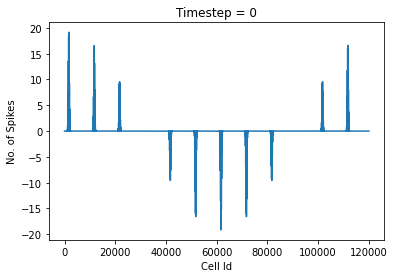

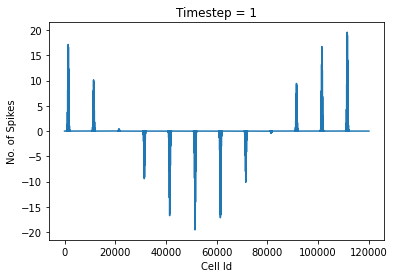

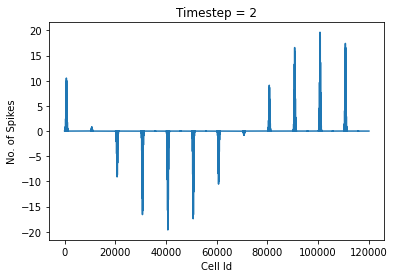

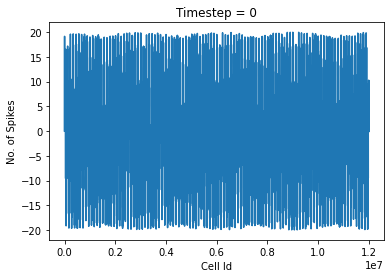

In [5]:
#@title To Test Modulated Activity 

lam = 20
orientation = 0
K = 100
n_max = 20
cell_num_root = 100
num_modules = 12
freq = 8 # frequency of the travelling wave
dt = 1e-2 # Timestep duration
s = 1.5

modules = multi_uniformModules(lam, orientation, cell_num_root,
                               num_modules, s=s)
trajectory = trajectory_1(total_steps=100)
modulating_factors = modulating_factor(modules, trajectory,
                                       freq, dt)

#plt.plot(trajectory[:,0], trajectory[:,1], 'k')
modulated_activity = modulated_firing(modules, trajectory,
                                      modulating_factors,
                                      cell_num_root, n_max, K)


# single timestep to take a snapshot of activity to plot

for i in range(3):
  timestep = i
  plot_stacked_activity(modulated_activity, timestep)


normal_activity = multi_firing_activity(modules, trajectory[0],
                                        n_max, K, s)
stacked_activity = modulated_activity[:, :].flatten('F')
plt.plot(stacked_activity)
plt.xlabel("Cell Id")
plt.ylabel("No. of Spikes")
plt.title("Timestep = " + str(0))
plt.show()

In [6]:
def plot_module_activity(firing_activity):
  """

  """

  activity = np.column_stack()

### Evaluation Functions

In [8]:
def mse_error(position, estimate):
  return np.sum((position - estimate)**2, axis = 1)


def evaluate_decoder(modules, position_range, step_size, args):
  """

  Returns:
    2-D error matrix corresponding to 
  """
  n_max = args['n_max']
  K = args['K']
  s = args['s']

  # initalize positions to run the encoder & decoder on
  x_range = y_range = np.arrange(0, position_range, step_size)
  positions = np.column_stack(x_range, y_range)

  activity = multi_firing_activity(modules, position, n_max, K, s)

  


def error_plot(position_error_matrix):
  """
  Input:
    position_error_matrix - 2-D matrix of erros corresponding to the position
                            coordinates
  """
  plt.imshow(position_error_matrix)